# CSE5CV Lab 04 - Object detection and segmentation

In this lab we will investigate the computer vision tasks beyond simple classification. By the end of this lab:

1. You should be able to describe the difference between classification, detection, semantic segmentation and instance segmentation.
2. You should know about the different evaluation metrics used for each computer vision task.
3. You should be familiar with how to download and use a pretrained MaskRCNN model.

## Colab preparation

Google Colab is a free online service for editing and running code in notebooks like this one. To get started, follow the steps below:

1. Click the "Copy to Drive" button at the top of the page. This will open a new tab with the title "Copy of...". This is a copy of the lab notebook which is saved in your personal Google Drive. **Continue working in that copy, otherwise you will not be able to save your work**. You may close the original Colab page (the one which displays the "Copy to Drive" button).
2. Run the code cell below to prepare the Colab coding environment by downloading sample files. Note that if you close this notebook and come back to work on it again later, you will need to run this cell again.

In [ ]:
!git clone https://github.com/ltu-cse5cv/cse5cv-labs.git
%cd cse5cv-labs/Lab04

## Packages

In this lab we will be using the following packages:
- `numpy` as always.
- *OpenCV* (`cv2`) to load images.
- *Matplotlib* (`matplotlib`) to display images and graphs.
- *Scikit-learn* (`sklearn`) to calculate metrics.
- `torchvision` to download Mask RCNN.
- *PyTorch* (`torch`) to create tensors to give Mask RCNN.

In [ ]:
import json
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy.spatial
import torch
import torchvision
import torchvision.transforms.functional as tvtf

# 1. Computer Vision tasks

There are four main computer vision tasks. Let's recap from the lecture!

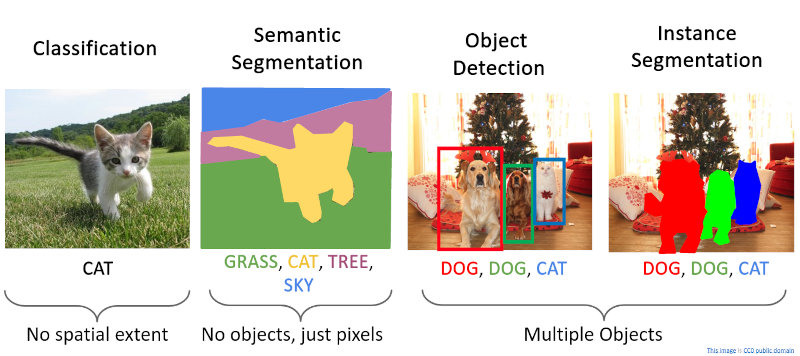

For an image:

1. Classification: what's the most salient object in it? The output is a single value.
2. Semantic segmentation: which pixels belong to which things? The output is shaped like an image, except instead of colour information in each pixel, you have the class.
3. Detection: what are all of the salient objects in it? The output is a set of boxes, describing the extent of each object in the image.
4. Instance segmentation: (a cross between detection and semantic segmentation) what are all of the salient objects in the image

We will now compare each of these computer vision tasks in different ways on a random image from the internet.

![Dogs in a park](https://images.unsplash.com/photo-1494947665470-20322015e3a8?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=matt-nelson-aI3EBLvcyu4-unsplash.jpg&w=640)

Image by Matt Nelson, [available on Unsplash](https://unsplash.com/photos/aI3EBLvcyu4)

# 2. Label shape

Here, we will explore the shape of the targets in each of these computer vision tasks.

In [ ]:
# load_img_rgb from Lab 1
def load_image_rgb(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

park_img = load_image_rgb('dog-park.jpg')
CLASS_MAP = {
    0: 'Background',
    1: 'Dog',
    2: 'Human',
    3: 'Cat',
    4: 'Zoo animal',
}

## 2.1 Classification

By now classification should be very familiar to you. For completeness, and to refresh your memory:

- Classes are represented by a single integer. These map to a class name string.
- Each image is assigned a single class.

**Question**: What class should `park_img` be?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    There are humans in the background, but the main class would probably be 'dog'. This example highlights the issue with giving a whole image a single label. You are missing a lot of detail about what's in an image.
</details>
<br />

Most images do not consist of a single object in an otherwise featureless white void. So, reducing an image to a single classification ignores a lot of the detail in the image. Consider robotic control - a major use of computer vision. For this, classification is necessary, but not sufficient, to understand your surroundings. A robot needs to know exactly where the floor and obstacles are. For this, we need a more detailed description of what's in an image.

## 2.2 Semantic Segmentation

Semantic segmentation is the process of classifying each pixel in an image. This is the first building block in understanding a scene. Since we are classifying each pixel, the data is shaped the same as the original image without the channel dimension. This image doesn't contain colour information, rather each "pixel" contains a class index.

Semantic segmentation opens up new forms of understanding in an image. Now that there is more than one class, and these classes are spatially related to one another, you can start to learn things like "people sit on chairs, so there shouldn't be chair pixels above person pixels", or "dogs are often seen on grass". These kinds of rules are learned implicitly in machine learning models by seeing lots of examples and can be extra clues to classification. There are even some models that can conditionally segment images based on natural language instructions. But let's not get ahead of ourselves.

**Question**: If we were to write a function which performed automatic segmentation on an image shaped `[224, 224, 3]`, then what would the shape of the output of that function be?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    The output of this hypothetical function would be shaped <code>[224, 224]</code>.
</details>
<br />

### 2.2.1 Polygon vs Mask

In practice, ground truth segmentations aren't stored as masks/images; instead they are stored as polygons with the understanding that the pixels they surround is all considered the same class. This saves a lot on disk space. Let's explore why and cement the terms "segmentation mask" and "segmentation polygon".

**Task**: Given a `segmentation_polygon`, use [cv2.fillPoly()](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga8c69b68fab5f25e2223b6496aa60dad5) to turn an array of zeros into a `segmentation_mask` (np.bool). *Hint*: You can use `==` to create a boolean mask of where in the image has been filled with the colour you give to `cv2.fillPoly()`

In [ ]:
segmentation_polygon = np.array([
    [0, 0],     [0, 300],   [50, 300],  [50, 175],  [150, 175],
    [150, 300], [300, 300], [300, 150], [278, 150], [278, 125],
    [300, 103], [275,  75], [250, 103], [272, 125], [272, 150],
    [250, 150], [250, 290], [200, 290], [200, 0],   [150, 0],
    [150, 125], [50, 125],  [50, 0],    [0, 0],
], dtype=np.int32) + 50
print('The shape of segmentation_polygon is:', segmentation_polygon.shape)

mask_img = np.zeros((400, 400), dtype=np.uint8)
# TODO use fillPoly to draw into mask_img

# TODO use a boolean operation to create a boolean mask


_ = plt.imshow(segmentation_mask, cmap='gray')

#### Task solution

In [ ]:
cv2.fillPoly(mask_img, [segmentation_polygon], color=255)
segmentation_mask = (mask_img == 255)

#### Question

**Question**: How many bits does it take to store `segmentation_polygon`? How many bits does it take to store `segmentation_mask`?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    <code>segmentation_polygon</code> is shaped <code>[24,2]</code> stored as <code>np.int32</code>. That means it takes 24x2x32=1536 bits to store <code>segmentation_polygon</code>.
    <br />
    <br />
    <code>segmentation_mask</code> is shaped <code>[400, 400]</code> stored as <code>np.bool</code>. That means it takes 400x400x1=160000 bits to store <code>segmentation_mask</code>. That's more than 100x as much space required.
</details>
<br />

## 2.3 Detection

While semantic segmentation is good for getting a general idea of where things are in your field of view (especially the ground and walls), it does not distinguish between individual people/cars/dogs/plates/whatever. So semantic segmentation is also not sufficient for controlling a robot to interact with instances of objects.

Detection is the process of putting a bounding box around every major salient object in the image. The data, is then a **set** of boxes, usually with a classification per box. Detection datasets use axis-aligned rectangles as bounding boxes for simplicity, rather than allowing any shape/orientation. Here's a handy chart to help you with this:

Axis-aligned bounding box

Since these are axis-aligned, these boxes can be represented with only 4 numbers. There are many different forms for these 4 numbers, though. They could indicate:

1. the (x, y) for the top-left corner and the bottom-right corner as `tlx`, `tly`, `brx`, `bry`.
2. the (x, y) for the top-left corner and list the box width and height as `tlx`, `tly`, `bw`, `bh`.
3. the (x, y) for the center of the box and list the box width and height as `cx`, `cy`, `bw`, `bh`.
4. any of the above, but with x and y swapped.
5. any of the above, but measured in pixels or normalised to image dimensions (0-1)

That's 12 different possible forms for the 4 numbers! It's important to know what form your annotations are in. If you have annotations, but no documentation, you can figure it out through trial and error and visualisation.

Detection also typically involves classification. So, all together, a single "detection" is 5 numbers.

## 2.4 Instance Segmentation

The advantage of segmentation over detection is that it tells you precisely where an object is in the image. The advantage of detection over segmentation is that it informs you of the boundaries specific individuals in an image. Instance segmentation combines both detection and segmentation to get both. As you might expect, this makes instance segmentation more difficult and more useful.

As with semantic segmentation, the ground truth segmentation data is stored as a polygon.

### 2.4.1 Instance Segmentation recap

An image contains many things. If we want to know what and where everything in an image is we should:

*Detect* all the instances -> *Classify* each detection -> Predict a *Segmentation mask* for each instance.

## 2.5 Let's label!

Let's manually add some labels to "dog-park.jpg" to get some practical experience performing these tasks ourselves before we use a computer to do it. There are a number of tools available to label images for detection and segmentation. We're going to use https://www.makesense.ai/ .

**Task**: Set up a makesense.ai project for labelling this image.
1. Click "Get started" in the bottom right corner.
2. Upload [dog-park.jpg](https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab04/dog-park.jpg).
3. Click "Object Detection".
4. Click "Load labels from file".
5. Upload [tutor_lbls/labels.txt](https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab04/tutor_lbls/labels.txt).

### 2.5.1 Detection

**Task**: Use the Rect tool to annotate rectangles around each of the dogs and humans. There should be 4 dog rectangles and 2 human rectangles. Guidelines:
1. Use as tight a box as you can get.
2. Do not guess about object extent. i.e. if an object is hidden, only put a box around the visible extents of the object.
   1. e.g. The brown dog to the left is largely hidden behind the front dog. So only put a narrow box.
   2. e.g. The back side of the husky is visible behind the brown dog's front leg, so the box should cover the backside, too, even though part of the husky is hidden.
3. Label the sitting humans only (not the arm holding the dog leads).

You can export the labels by clicking "Actions" > "Export Annotations" > "A .zip package containing files in YOLO format". I have already done this for you, and the resulting annotation file is available in `tutor_lbls/dog-park.txt`. The content of the file looks like this:

```
1 0.530314 0.594711 0.175938 0.677422
1 0.743306 0.651839 0.206691 0.497299
1 0.363662 0.550676 0.181831 0.429147
1 0.450671 0.583155 0.078841 0.451510
2 0.173308 0.358465 0.150579 0.298167
2 0.719156 0.330778 0.115775 0.183160
```

**Task**: Load the `tutor_lbls/dog-park.txt` file into Python such that each detection is represented as `class_id`, `tlx`, `tly`, `brx`, `bry` in a `np.array` shaped `[6, 5]`. *Note*: They are stored in the file as `cx`, `cy`, `bw`, `bh`, normalised to the image dimensions. *Note2*: We will visualise these later, if the boxes don't seem to cover the right parts, come back here and double check your solution with the answer.

In [ ]:
# TODO: write function here
#   open text file, split each row up, store numeric values in `rows`
#def load_detections(fname):

detection_lbls = load_detections(Path('tutor_lbls') / 'dog-park.txt')
assert tuple(detection_lbls.shape) == (6, 5)

#### Task solution

In [ ]:
def load_detections(fname):
    with open(fname) as detection_file:
        rows = []
        for line in detection_file:
            p = line.split(' ')
            x, y = float(p[1]), float(p[2])
            w, h = float(p[3]), float(p[4])
            rows.append([int(p[0]), x-w/2, y-h/2, x+w/2, y+h/2])
    return np.array(rows)

### 2.5.2 Segmentation

We will annotate instance segmentation labels on our image.

**Task**: Add polygons to all of the dogs and humans in the image. Guidelines:

1. You don't have to get it perfect (unless you are a perfectionist).
2. Where the edges are indistinct (e.g. blur and fur), choose a point that is about 50% the object and 50% the background.
3. Where an object is obscured, and you can see the object behind the other object, make the polygon extend over the obscuring object.
4. Where an object is obscured, and you can't see the extent of the obscured object behind the obscuring object, make the polygon end at the edges of the obscuring object.

Tip: You can add or edit the points later, but you can't delete points. So always prefer fewer points on your first pass. You can correct it afterwards if you want.

You can export the labels by clicking "Actions" > "Export Annotations" > "Single file in COCO JSON format.". I have already done this for you, and the resulting annotation file is available in `tutor_lbls/dog-park-coco-seg.json`.

In [ ]:
# Loading the segmentation polygons is provided for you
def load_segmentation(fname):
    with open(fname) as park_seg_f:
         segs = json.load(park_seg_f)

    # Flatten segs for our simple case.
    # Note: s['segmentation'][0] stores the xs and ys interleaved
    #       we store it as a list of [(x,y), ...]
    # Note: s['bbox'] stores as tlx, tly, bw, bh
    #       we store it as tlx, tly, brx, bry.
    # Note: both are stored as pixels, but we use normalised to image dimensions in this lab
    seg_polygons = []
    seg_det = []
    for s in segs['annotations']:
        # Annotations are 1-indexed, but we use 0-indexing here
        cl = (s['category_id'] - 1)
        poly = np.stack([s['segmentation'][0][::2], s['segmentation'][0][1::2]], axis=-1)
        tlx, tly, bw, bh = s['bbox']
        bbox = (tlx, tly, (tlx+bw), (tly+bh))
        seg_polygons.append((cl, poly))
        seg_det.append((cl, *bbox))
    seg_det = np.array(seg_det)

    h, w = park_img.shape[:2]
    for class_id, poly in seg_polygons:
        # Modifying `poly` in-place to be a proportion of the image size, rather than be measured in pixels
        poly /= (w, h)
    seg_det /= (1, w, h, w, h)
    return seg_polygons, seg_det

seg_polygons, seg_det = load_segmentation(Path("tutor_lbls") / "dog-park-coco-seg.json")
for i, (class_id, poly) in enumerate(seg_polygons):
    print(f'Polygon {i}  :  Class: {CLASS_MAP[class_id]:6s}  |  Points:', poly.shape)

# 3. Visualisation

Now we have seen a common form for detections and segmentations, we need to be able to visualise them. This is especially important when you have a model predicting detections and segmentations, as visualising these can give you a quick understanding of how well the model is performing.

## 3.1 Detection

The typical method for displaying detections on an image is to draw a rectangle and then put the text above the box indicating the class name. Unfortunately there aren't many easily available implementations of this. Fortunately it's relatively easy to implement ourselves. In the next few tasks you'll implement functions to create an image like this from your labels:

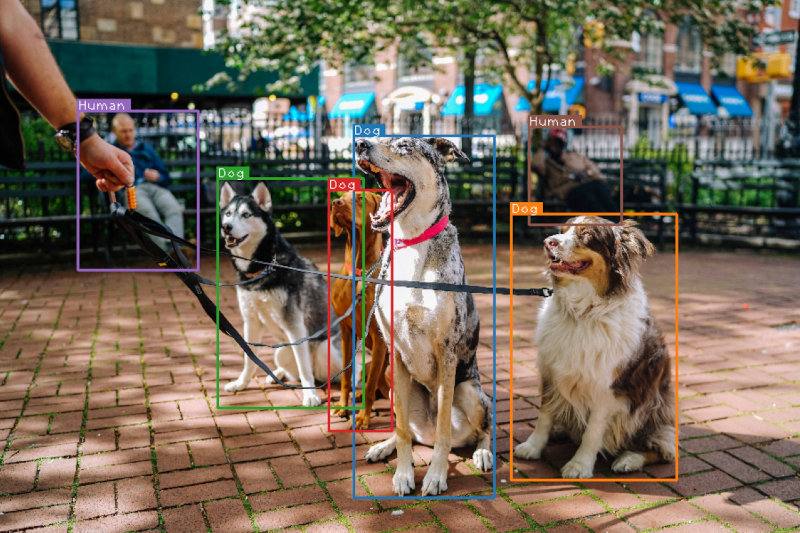

<details>
<summary style='cursor:pointer;'><u>More details: Label Ambiguity</u></summary>
    Forget about model performance for a second and think about how to label an image for detection. What constitutes a "major salient object" is up for debate. This especially becomes an issue as objects get smaller, or are partially obstructed in images. Consider the following images:
    <table>
        <tr>
            <td><img src='./img/tables.jpg' width="400"/></td>
            <td><img src='./img/apples.jpg' width="200"/></td>
        </tr>
    </table>
    <br />
    <br />
    You can see that there are a lot of obstructions. In the case of the tables/chairs; do you label a whole chair, or do you label the top half and bottom half separately? For the apples, do you label every one individually? What about the mostly hidden ones? How much of an apple do you choose to include? Or do you label regions and just say "apple"? But that would imply there was just one large apple. Should you include the really small chairs in the background?
    <br />
    <br />
    These are pathological images, specifically selected to highlight an issue; most images aren't this bad, but issues like these still occur very frequently. Different detection/segmentation datasets will set different guidelines on how to label the dataset. But there's always going to be a bit of ambiguity involved. And datasets are usually labelled by underpaid interns or crowdsourced at a few cents per label, so these aren't necessarily followed perfectly, either.
    <br />
    <br />
    Just some food for thought.
</details>
<br />

**Task**:
1. Create a `park_img_rescaled` that is rescaled to have a height of 600 pixels using [cv2.resize()](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d). (The original is very large)
2. Create a `draw_detections()` function which takes `park_img_rescaled` and `detections_rescaled` and draws detection boxes on it using [cv2.rectangle()](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9).
3. Create a `annotate_class()` function which takes `park_img_rescaled` and `detections_rescaled` and write the class name above each box as shown in the above image using [cv2.rectangle()](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) and [cv2.putText()](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

In [ ]:
# Get the matplotlib colours for consistency
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [ ]:
NEW_HEIGHT = 600
scale = NEW_HEIGHT/park_img.shape[0]

# TODO: Rescale park_img
# park_img_rescaled =

# Scale coordinates of `detection_lbls` up to rescaled image size
h, w = park_img_rescaled.shape[:2]
detection_lbls_rescaled = (detection_lbls * (1, w, h, w, h)).astype(np.int32)

# TODO: Put draw_detections() here
#       Use a loop and colours[i]
#def draw_detections(img, det, colours=COLOURS):

# TODO: Put annotate_class() here
#       Use a loop and colours[i]
#       The text is 12 pixels high,
#       the box on top should be 13 pixels high and
#              12*len(class_name) pixels wide
#       For putText(), use fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1.0, color=(255,)*3
# OPTIONAL: If given a list of confidences (conf), also display the confidence on the after the class
#def annotate_class(img, det, conf=None, colours=COLOURS, class_map=CLASS_MAP):

# Create a fresh copy to draw on
img = park_img_rescaled.copy()
draw_detections(img, detection_lbls_rescaled)
annotate_class(img, detection_lbls_rescaled)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.imshow(img)
_ = ax.axis('off')

#### Task solution

In [ ]:
# Rescale park_img
park_img_rescaled = cv2.resize(park_img, dsize=(0, 0),
                               fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

def draw_detections(img, det, colours=COLOURS):
    for i, (cl, tlx, tly, brx, bry) in enumerate(det):
        i %= len(colours)
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)

def annotate_class(img, det, conf=None, colours=COLOURS, class_map=CLASS_MAP):
    for i, (cl, tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[cl]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1

        cv2.rectangle(img,
                      (tlx-offset, tly-offset-12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i],
                      thickness=cv2.FILLED)

        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1), fontFace=ff, fontScale=1.0, color=(255,)*3)


## 3.2 Instance Segmentation

Now, we need to visualise the segmentation polygons/masks within the detections.

**Task**: Create a `draw_instance_segmentation_poly()` function which paints segmentation masks over an `img` using [cv2.fillPoly()](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga311160e71d37e3b795324d097cb3a7dc) on an [np.zeros_like(img)](https://numpy.org/doc/1.20/reference/generated/numpy.zeros_like.html) and blends this with the original image with [cv2.addWeighted()](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19)

In [ ]:
# TODO: Write draw_instance_segmentation
#def draw_instance_segmentation_poly(img, polygons)

# Rescale segmentation polygons and separate bboxes from segmentation labels
h, w = park_img_rescaled.shape[:2]
seg_polygons_rescaled = []
for class_id, poly in seg_polygons:
    poly = (poly * (w, h)).astype(np.int32)
    seg_polygons_rescaled.append((class_id, poly))
seg_det_rescaled = (seg_det * (1, w, h, w, h)).astype(np.int32)

# Create a fresh copy to draw on
img = park_img_rescaled.copy()
draw_instance_segmentation_poly(img, seg_polygons_rescaled)
draw_detections(img, seg_det_rescaled)
annotate_class(img, seg_det_rescaled)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.imshow(img)
_ = ax.axis('off')

#### Task solution

In [ ]:
def draw_instance_segmentation_poly(img, polygons):
    ''' Draws coloured polygons masks over img '''
    filled = np.zeros_like(img)
    for i, (class_id, poly) in enumerate(polygons):
        cv2.fillPoly(filled, [poly], color=COLOURS[i])
    # Blend original and filled into a composite image
    cv2.addWeighted(img, 0.75, filled, 0.75, 1.0, dst=img)

## 3.3 Semantic Segmentation

We haven't explicitly labelled our data for semantic segmentation, but we can utilise the existing polygons to create a semantic segmentation mask for the whole image. This one has been provided for you.

In [ ]:
def draw_semantic_segmentation(img, polygons):
    '''
    Draws coloured polygons over img.
    Calculates segmentation mask over img.
    Assumes class 0 if not otherwise filled with a polygon.
    '''
    img = img.copy()
    # Filled/seg_mask defaults to class 0
    filled = np.ones_like(img) * COLOURS[0]
    filled = filled.astype(np.uint8)
    seg_mask = np.zeros(img.shape[:2])

    for class_id, poly in polygons:
        c = COLOURS[class_id]
        # Draw in filled
        cv2.fillPoly(filled, [poly], color=c)
        # Finds all positions in filled that is the specified colour
        class_mask = (filled == c)[:, :, 0]
        # Sets all those positions in seg_mask to be the class_id
        seg_mask[class_mask] = class_id

    # Blend original and filled into a composite image
    cv2.addWeighted(img, 0.75, filled, 0.75, 1.0, dst=img)

    return img, seg_mask

# Create a fresh copy to draw on
img = park_img_rescaled.copy()
img, seg_mask = draw_semantic_segmentation(img, seg_polygons_rescaled)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.imshow(img)
_ = ax.axis('off')

We now can manually evaluate detections and segmentation polygons visually. But what if we want to measure thousands of images? We need a numerical way to evaluate detection/segmentation performance.

# 4. Evaluation

These new challenging tasks allow models to predict much more detailed information, but we still need to be able to measure how correct the model is. There is a big difference between what is possible for a model to predict and what it actually predicts. In this section we will talk about the main metrics used in each task.

## 4.1 Classification

First, a refresher on binary classification metrics:

1. Count up true positives (`TP`), true negatives (`TN`), false positives (`FP`), false negatives (`FN`)
2. Calculate combined metrics:
    1. $accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
    2. $recall = \frac{TP}{TP + FN}$
    3. $precision = \frac{TP}{TP + FP}$
    4. $F1 \space score = \frac{2 \cdot (precision \cdot recall)}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$

Although the library functions will do these calculations for you, remembering how they're calculated will help you understand later parts of this lab.

Remember that in the multi-class classification case these are calculated per-class first. Here, we will find the average across all classes, rather than displaying it per-class.

<details>
<summary style='cursor:pointer;'><u>Derivation of F1 score formula that uses TP, FP and FN</u></summary>

The formula using TP, FP and FN is on Wikipedia, but you can show it from the definitions of recall, precision and F1 score, too.
    
$ \Large{ F1 = \frac{2 \cdot precision \cdot recall}{precision + recall} } $

$ \Large{ F1 = \frac{2 \cdot \frac{TP^2}{\left(TP + FP\right)\left(TP + FN\right)}}{\frac{TP}{TP + FP} + \frac{TP}{TP + FN}} } $

$ \Large{ = \frac{2 \cdot \frac{TP^2}{(TP + FP)(TP + FN)}}{\frac{TP(TP + FN)}{(TP + FP)(TP + FN)} + \frac{TP(TP + FP)}{(TP + FP)(TP + FN)}} } $

$ \Large{ = \frac{2 \cdot \frac{TP^2}{(TP + FP)(TP + FN)}}{\frac{TP(TP + FN) + TP(TP + FP)}{(TP + FP)(TP + FN)}} } $
    
$ \Large{ = 2 \cdot \frac{TP^2}{(TP + FP)(TP + FN)} \cdot \frac{(TP + FP)(TP + FN)}{TP(TP + FN) + TP(TP + FP)} } $

$ \Large{ = 2 \cdot \frac{TP^2}{TP(TP + FN) + TP(TP + FP)} } $

$ \Large{ = 2 \cdot \frac{TP}{TP + FN + TP + FP} } $

$ \Large{ = \frac{2 \cdot TP}{2 \cdot TP + FN + FP} } $
    
</summary>

In [ ]:
fake_preds = [2, 1, 2, 3, 4, 4, 3, 4, 3, 2, 4, 1, 0, 4, 2]
fake_lbls =  [2, 1, 1, 4, 0, 3, 3, 4, 3, 2, 2, 1, 0, 4, 2]

# Print metrics
acc = sklearn.metrics.accuracy_score(fake_lbls, fake_preds)
recall = sklearn.metrics.recall_score(fake_lbls, fake_preds, average='weighted')
precision = sklearn.metrics.precision_score(fake_lbls, fake_preds, average='weighted')
f1 = sklearn.metrics.f1_score(fake_lbls, fake_preds, average='weighted')

print(f'Accuracy: {acc:0.3f}   Recall: {recall:0.3f}   Precision: {precision:0.3f}   F1: {f1:0.3f}')

# Show confusion matrix
cm = sklearn.metrics.confusion_matrix(y_true=fake_lbls, y_pred=fake_preds)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp = cm_disp.plot(include_values=True, cmap='plasma_r', ax=None, xticks_rotation='horizontal')

## 4.2 Segmentation

The most commonly used metrics for evaluating segmentation are the Dice coefficient (DSC) and Intersection over Union (IoU). Here, we provide some relatively poor segmentation masks (just boxes), and we'll evaluate how good those are with these metrics. We will also load up the tutor's labels. You labelled the image, so your labels are considered "correct", and we are measuring how close the tutor was to your correct labels.

These metrics measure similarity between segmentation masks and are thus applicable to both semantic segmentation and instance segmentation.

In the code cell below we will visualise the poor prediction, the tutor's annotations and your own annotations from earlier in the lab.

In [ ]:
pred_dogs_poly = np.array([
    [250, 250],
    [250, 550],
    [750, 550],
    [750, 250],
    [250, 250],
])
pred_human_poly1 = np.array([
    [100, 125],
    [100, 300],
    [200, 300],
    [200, 125],
    [100, 125],
])
pred_human_poly2 = np.array([
    [600, 150],
    [600, 250],
    [700, 250],
    [700, 150],
    [600, 150],
])
pred_polygons = [
    (1, pred_dogs_poly),
    (2, pred_human_poly1),
    (2, pred_human_poly2),
]

h, w = park_img_rescaled.shape[:2]
tutor_seg_polygons, tutor_seg_det = load_segmentation(Path("tutor_lbls") / "dog-park-coco-seg.json")
tutor_seg_polygons_rescaled = [
    (class_id, (poly * (w, h)).astype(np.int32))
    for class_id, poly in tutor_seg_polygons
]

img_pred, seg_mask_pred = draw_semantic_segmentation(park_img_rescaled, pred_polygons)
img_lbl, seg_mask_lbl = draw_semantic_segmentation(park_img_rescaled, seg_polygons_rescaled)
img_tutor, seg_mask_tutor = draw_semantic_segmentation(park_img_rescaled, tutor_seg_polygons_rescaled)

def show_image(ax, img, title):
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

fig, axes = plt.subplots(4, 3, figsize=(18, 18))
show_image(axes[0, 0], img_pred, 'Guess/Prediction')
show_image(axes[1, 0], (seg_mask_pred == 0), CLASS_MAP[0])
show_image(axes[2, 0], (seg_mask_pred == 1), CLASS_MAP[1])
show_image(axes[3, 0], (seg_mask_pred == 2), CLASS_MAP[2])

show_image(axes[0, 1], img_tutor, 'Tutor\'s annotations')
show_image(axes[1, 1], (seg_mask_tutor == 0), CLASS_MAP[0])
show_image(axes[2, 1], (seg_mask_tutor == 1), CLASS_MAP[1])
show_image(axes[3, 1], (seg_mask_tutor == 2), CLASS_MAP[2])

show_image(axes[0, 2], img_lbl, 'Ground Truth (Your annotations)')
show_image(axes[1, 2], (seg_mask_lbl == 0), CLASS_MAP[0])
show_image(axes[2, 2], (seg_mask_lbl == 1), CLASS_MAP[1])
show_image(axes[3, 2], (seg_mask_lbl == 2), CLASS_MAP[2])

**Question**: Why does it appear that the background class shows the segmentation masks of the dogs and humans put together?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
White in the segmentation mask visualisations indicates a positive. i.e. For each class, white means that the pixel is that class. Then, for the background class we actually see a negative image; the dogs and humans are all negative, but the segmentation masks are all still visually distinct.
</details>

### 4.2.1 Dice coefficient (DSC)

The Dice coefficient (DSC) ends up being the same as the F1 score, but has a different formulation. Instead of 'precision' and 'recall', we measure the areas of predictions vs labels. We will now explain why this is the same as F1. The Dice coefficient is defined as:

$DSC = \frac{2 | X \cap Y |}{|X| + |Y|}$

Where $X$ are the pixels predicted for the class of interest, and $Y$ are the pixels labelled as the class of interest. If we treat each pixel as an individual data point, then:

 - $|X \cap Y| = TP$
     - The pixels where the predictions agree with the labels
 - $|X| = (TP+FP)$
     - The total number of pixels predicted as this class.
 - $|Y| = (TP+FN)$
     - The total number of pixels labelled as this class.

Which means that it is equivalent to:

$DSC = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$

Which is an alternate form of the equation for F1 score.

**Task**: Calculate the dice coefficient for the guessed predictions `seg_mask_pred` and tutors annotations `seg_mask_tutor` using `sklearn.metrics.f1_score()`. *Hint*: flatten your images to make them 1D.

In [ ]:
# TODO: flatten seg_mask_pred, seg_mask_tutor, and seg_mask_lbl
#seg_mask_lbl_flat = ...
#seg_mask_pred_flat = ...
#seg_mask_tutor_flat = ...

# TODO: use sklearn.metrics.f1_score() to calculate dice coefficient for
#  guessed predictions and the tutor's annotations
#f1_pred = ...
#f1_tutor = ...

print('Dice coefficient / f1 score')
print(f'Guess: {f1_pred*100:5.1f}%  Tutor: {f1_tutor*100:5.1f}%')

#### Task solution

In [ ]:
seg_mask_lbl_flat = seg_mask_lbl.reshape(-1)
seg_mask_pred_flat = seg_mask_pred.reshape(-1)
seg_mask_tutor_flat = seg_mask_tutor.reshape(-1)

f1_pred = sklearn.metrics.f1_score(seg_mask_lbl_flat, seg_mask_pred_flat, average='weighted')
f1_tutor = sklearn.metrics.f1_score(seg_mask_lbl_flat, seg_mask_tutor_flat, average='weighted')

### 4.2.2 Intersection over Union (IoU)

Intersection over Union has a similar definition to the Dice coefficient. In fact, they are linked pretty directly; a high dice coefficient always means a high IoU. The name tells you the formulation:

$ IoU = \frac{|X\cap Y|}{|X \cup Y|} $

Where $X$ are the pixels predicted for the class of interest, and $Y$ are the pixels labelled as the class of interest. If we treat each pixel as an individual data point, then:

 - $|X \cap Y|$
     - The pixels where the predictions agree with the labels.
 - $|X \cup Y|$
     - The pixels which are either predicted or labelled.

Intersection over Union is also known as the Jaccard Index or Jaccard score. We can use the [`sklearn.metrics.jaccard_score()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) to calculate the IoU.

**Task**: Calculate the IoU for the guessed predictions `seg_mask_pred` and tutor's annotations `seg_mask_tutor`.

In [ ]:
# TODO: Calculate the iou for the predictions and for the tutor's annotations
#iou_pred = ...
#iou_tutor = ...

print('IoU / Jaccard index')
print(f'Guess: {iou_pred:1.3f}  Tutor: {iou_tutor:1.3f}')

#### Task solution

In [ ]:
iou_pred = sklearn.metrics.jaccard_score(seg_mask_lbl_flat, seg_mask_pred_flat, average='weighted')
iou_tutor = sklearn.metrics.jaccard_score(seg_mask_lbl_flat, seg_mask_tutor_flat, average='weighted')

#### Question

**Question**: Imagine two squares of side length 2. If you overlap these such that half of the area of each square overlaps with the other, what is the IoU? Calculate it by hand and then compare your answer to the output of the cell below.

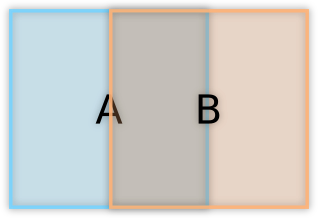

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
The intersection is 2, the union is 6. Thus, the IoU is 2/6 = 1/3.
</details>

In [ ]:
sq_a = np.array([
    [1, 1, 0],
    [1, 1, 0]
])
sq_b = np.array([
    [0, 1, 1],
    [0, 1, 1],
])
iou = sklearn.metrics.jaccard_score(sq_a.flatten(), sq_b.flatten())
print(iou)

## 4.3 Detection

The most commonly used metric for image detection is mean average precision (mAP). To calculate mAP, every prediction must have a confidence score associated with it. This confidence is an extra predicted value. So, a bounding box "prediction" is actually 6 numbers: the class, a confidence and the 4 numbers of the bounding box (e.g. `tlx`, `tly`, `brx`, `bry`).

Calculating mean average precision is more involved and esoteric than any of the other metrics we have looked at. Here are the steps to calculating mAP:

 1. Determine whether each prediction matches a ground truth using IoU thresholds.
 2. For each prediction, calculate the precision/recall if you included that prediction and all predictions with a higher confidence.
 3. Take an average of the precisions, weighted by the change in recall. This is the average precision (AP). In practice this is actually the area under a "precision-recall" curve.
 4. Take the unweighted average over all classes. This is the mean average precision (mAP)

We will now go through each of these steps in brief detail. Astoundingly, there appears to be no library function for calculating mAP for image detection in any of the libraries we have installed, so we provide a numpy implementation for use in this lab. Read through it if you would like, but this is not necessary for completing the rest of this lab.

<details>
<summary style='cursor:pointer;'><u>Confused? You are not alone</u></summary>
It is a complicated metric to calculate. There's no standard implementation for calculating mAP (at least, not one that we're aware of). The algorithm is relatively well known, of course, but there are subtleties in the details that aren't immediately obvious (e.g. how to handle multiple detections of the same ground truth) which can differ betwen implementations.

In any case, we've done our best to collate information about this metric so that you can understand it well enough to know what it is and why it's a good metric. We provide an implementation without guarantee of it working for edge cases. Hopefully one day <i>skimage</i> will implement a well-tested mAP implementation for image detection.
</details>

<details>
<summary style='cursor:pointer;'><u>More details: Retrieval systems</u></summary>
Mean average precision is a metric from retrieval systems, so if you google it, you will likely find tutorials that describe it with respect to retrieval systems. Retrieval is the task of searching a database for a relevant document/image/thing based on a search query. Google is the most well known retrieval system.

In retrieval nomenclature, a "relevant" document is what you hope to find. The equivalent in image detection is that we hope to find an "accurate detection", but "accurate" is a sliding scale based on IoU threshold. So, mAP is more complicated in image detection. For a retrieval system, all datasets come with the documents pre-labelled as "relevant" or "not relevant", but for image detection, we must always talk in reference to an IoU threshold for determining an "accurate detection"/"true positive".

Be careful with these descriptions, however. They will often talk about "changing a threshold". In the context of information retrieval, they are <b>not</b> talking about the IoU threshold. They are talking about changing the cutoff for the confidence. Changing this cutoff is step 2 from above. We will consider as many cutoffs as there are detections to calculate a single AP and average across them; that's what the "average" part of "average precision" means.
</details>

<details>
<summary style='cursor:pointer;'><u>More details: Alternate mAPs for image detection</u></summary>
There are two main datasets that everyone refers to when talking about mAP for image detection: COCO and PASCAL VOC. These are the quintessential image detection datasets in modern computer vision. However, they use their own evaluation kits to actually calculate mAP. That is, they use different implementations of mAP, and actually calculate the values differently. In fact, COCO has changed how they calculate mAP over time. In this lab we are describing the most modern COCO method for calculating mAP.

This lack of consistency is probably a big factor in preventing a standardised implementation of mAP for image detection from making it's way into OpenCV, scikit-learn or scikit-image. Now, it is important to note that there is a mean average precision implementation in scikit-learn ([sklearn.metrics.average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)), but this is an implementation for the information retrieval case, not for images. Specifically, it does not incorporate IoUs or IoU thresholds, and it does not consider the possibility of a missed detection.
</details>

<details>
<summary style='cursor:pointer;'><u>More details: Terminology: AP vs mAP</u></summary>
The terminology for mean average precision isn't very clear. Some sources claim the "mean" refers to averaging over all classes, while other claim it is an average over different IoU thresholds. The former is more common and in this lab we'll use that. Sources agree that you should take an unweighted average across classes, though. So, you calculate the AP per class, then average without concern for the number of bounding boxes for each class. e.g. if there's 1000 "dog" boxes with an AP of 0.8 and 5 "human" boxes with an AP of 0.6, then, the mAP is 0.7

Official COCO documentation actually only mentions "AP" as a metric, but it actually means "mAP" based on this definition.

Some sources use different notation to denote the IoU threshold. Sometimes it's a percentage like AP50, sometimes it's a decimal like AP\@0.5. They mean the same thing, though, so don't get confused. If you see (mean) average precision for image detection mentioned with a number, that number is the IoU threshold.
</details>

<details>
<summary style='cursor:pointer;'><u>More details: AP vs AR</u></summary>
Although less common, average recall (AR) is sometimes used as well as average precision (AP). To calculate average recall, instead of taking a weighted average of precision using recalls in step 3, you take a weighted average of recalls using precision. This is just for your information. We won't go through an example in this lab.
</details>

<details>
<summary style='cursor:pointer;'><u>More details: Is average precision really an average?</u></summary>
Later in this section we show a recall-precision curve, and say that "average precision" is the area under that curve. You should remember from high school maths the methods for approximating an integral. The left-hand rule, or the trapezoidal rule, perhaps. Calculating the area under the curve using the trapezoidal rule is perfectly accurate using discrete data. In any case, the formulation of the left-hand rule of approximating an integral turns out to be the same as taking a weighted sum, which, if all the weights are the same, also equals the average.

The Area Under the Curve (AUC) is a common metric in information retrieval, and is what we actually care about. And, the trapezoidal rule for calculating area under a curve is clearly better than using the left-hand rule. So, in reality we actually measure the area using trapezoids. But we still call the value at the end an "average" precision, even though that's not quite what it is.

The metric should really be called "mean area under the curve".
</details>
<br />


**In your own time**: Here's a good tutorial covering the details of how to calculate mAP for image detection: https://www.youtube.com/watch?v=FppOzcDvaDI

<details>
<summary style='cursor:pointer;'><u>More links: A curated list for understanding mAP</u></summary>
Here are some more links to help you understand mAP:

Some relevant, short (&lt;10mins) videos from a series by Victor Lavrenko from the perspective of information retrieval:

  - https://www.youtube.com/watch?v=oqyrK2lWAJw
  - https://www.youtube.com/watch?v=H7oAofuZjjE
  - https://www.youtube.com/watch?v=pM6DJ0ZZee0

A written article:
https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2
</details>
<br />

In the code cell below, we implement mAP in numpy. This section takes heavy inspiration from the linked video. If you get lost, you might try watching the first 8 minutes of the linked video.

In [ ]:
def bbox_iou_matrix(a, b):
    '''
    Vectorised iou calculation for bbox predictions.

    Parameters:
        a (np.array [N, 4]): array of N boxes, each as [tlx, tly, brx, bry]
        b (np.array [M, 4]): as `a`, but with M boxes

    Returns:
        np.array [N, M]: the iou for every pair of boxes.
    '''
    a = a[:, None] # [N, 1, 4]
    b = b[None, :] # [1, M, 4]

    tlx_a, tly_a, brx_a, bry_a = [a[..., i] for i in range(4)]
    tlx_b, tly_b, brx_b, bry_b = [b[..., i] for i in range(4)]

    # Find the overlap/intersection
    # note: np.maximum() != np.max()
    tlx_overlap = np.maximum(tlx_a, tlx_b)
    tly_overlap = np.maximum(tly_a, tly_b)
    brx_overlap = np.minimum(brx_a, brx_b)
    bry_overlap = np.minimum(bry_a, bry_b)
    # Clipping to account for non-overlapping
    intersection = (brx_overlap - tlx_overlap).clip(0) * (bry_overlap - tly_overlap).clip(0)

    area_a = abs((brx_a - tlx_a) * (bry_a - tly_a))
    area_b = abs((brx_a - tlx_a) * (bry_a - tly_a))
    union = area_a + area_b - intersection

    return intersection / union

def determine_positives(pred, gt, iou_thresh=0.5):
    '''
    Determines which predictions are 'true positive' by comparing IoU with all of the gt.

    Parameters:
        pred (np.array [N, 7]): array of N predictions, each as
               [train_idx, class_prediction, confidence, tlx, tly, brx, bry]
        gt (np.array [M, 7]): as pred excpet are ground truth boxes.
        iou_thresh (float): threshold for prediction being considered to match a gt.

    Returns:
        np.array [N,]:
    '''
    N = pred.shape[0]
    M = gt.shape[0]

    # Sort all predictions by confidence.
    sort_idxs = np.argsort(-pred[:, 2])
    unsort_idxs = np.argsort(sort_idxs)
    pred = pred[sort_idxs]

    # Calculate IoUs for all pairs of det/gt
    ious = bbox_iou_matrix(pred[:, 3:], gt[:, 3:])
    # ious shaped [N, M]

    # For each gt, find the prediction with the highest confidence above the iou threshold
    above_thresh = (ious >= iou_thresh)*1
    # above_thresh is a 2D array [N, M] with 0s for pairs that don't meet the iou threshold
    #    and 1s for pairs which do.

    pred_match_gt = above_thresh.argmax(axis=0)
    # pred_match_gt is a 1D array [M,] of the prediction indices with the highest
    #    confidence above the iou threshold for each ground truth

    n_gt_match = np.zeros(pred.shape[0])
    # n_gt_match is a 1D array [N,] indicating if the prediction is a TP.

    # https://stackoverflow.com/questions/24099404/numpy-array-iadd-and-repeated-indices
    np.add.at(n_gt_match, pred_match_gt, above_thresh[pred_match_gt, np.arange(M)])

    # Goodness, numpy can be powerful. This last line of code needs a lot of explanation.
    #  it says: add the value from above_thresh for each prediction index from pred_match_gt

    # This covers several edge cases at once:
    #  One gt that matches two pred  - Only one pred is included in pred_match_gt.
    #                                  the one with the lower confidence is considered a false positive.
    #  Two gt that match   one pred  - Add 1 for each gt; in this case, will add 2.
    #  No predictions match a gt     - above_thresh will be 0 if the best match wasn't above the threshold

    is_tp = (n_gt_match >= 1)*1
    # Unsort by confidence before returning
    return is_tp[unsort_idxs]

def precision_recall_curve(is_tp, confs, n_true, eps=1e-8):
    '''
    Roughly equivalent to sklearn.metrics.precision_recall_curve,
    except that a ground truth can have 0 or 1 predictions for it (missed detections)

    Parameters:
        is_tp (np.array [N,]): array listing TP as >=1s, and FP as 0s for predictions
        confs (np.array [N,]): parallel array of confidences

    Returns:
        np.array [N,]: cumulative precisions
        np.array [N,]: cumulative recalls
    '''
    # Sort by confs
    order = (-confs).argsort()
    is_tp = is_tp[order]
    confs = confs[order]

    # Cumulative sum true positives and number of predictions
    TP = is_tp.cumsum()
    n_pred = np.arange(len(is_tp))+1

    # Divide by different subsets to find recall/precision
    precisions = TP / (n_pred + eps)
    recalls = TP / (n_true + eps)

    # Append 100% precision and 0% recall to the start to indicate
    # what these values are before any predictions are included.
    precisions = np.concatenate([[1], precisions])
    recalls = np.concatenate([[0], recalls])

    return precisions, recalls


def mean_average_precision(pred_boxes, true_boxes, iou_thresh=0.5):
    '''
    Calculates mean average precision over all images for all classes.

    'average precision' includes all images for a class.
    'mean average precision' is an unweighted average of 'average precisions'

    Parameters:
        pred_boxes (np.array [N, 7]): array of N predictions, each as
                 [train_idx, class_prediction, confidence, tlx, tly, brx, bry]
        true_boxes (np.array [M, 7]): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    '''
    # Collect average precision per class
    average_precisions = []
    classes = set(true_boxes[:, 1])
    for c in classes:
        # Get only the boxes for class with index c
        detections = pred_boxes[pred_boxes[:, 1] == c]
        ground_truths = true_boxes[true_boxes[:, 1] == c]

        total_true_bboxes = len(ground_truths)

        # Collect true positives from all images
        is_tps = []
        confs = []
        for i in set(ground_truths[:, 0]):
            # Get only the boxes for image with index i
            det_i = detections[detections[:, 0] == i]
            gt_i = ground_truths[ground_truths[:, 0] == i]

            is_tp = determine_positives(det_i, gt_i, iou_thresh)

            is_tps.append(is_tp)
            confs.append(det_i[:, 2])

        is_tps = np.concatenate(is_tps)
        confs = np.concatenate(confs)

        # Find average_precision for this class
        precision, recall = precision_recall_curve(is_tps, confs, total_true_bboxes)
        average_precisions.append(np.trapz(precision, recall))

    return sum(average_precisions) / len(average_precisions)

### 4.3.1 Determine True Positive

In all previous metrics we've looked at, we have defined a "true positive" as a prediction that is the same class as the label. However, determining if a detection is a "true positive" is very difficult. Classes are categorical, thus we can clearly delineate between them. However, detections are continuous values, so we cannot rely on exact matching. Consider our set of labelled boxes `detection_lbls`. If we add 5 pixels to all the positions the boxes will still cover the objects very well. However, there comes a point when a detection just isn't close enough to be considered "accurate"/"true positive". Below we show offsetting the ground truth for the dog park image, and a new image with hypothetical predictions that aren't so perfect.

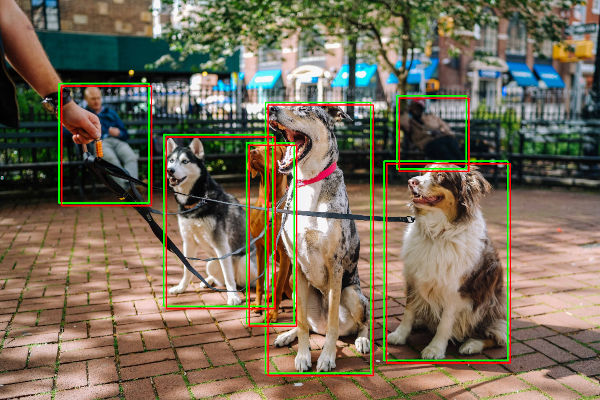

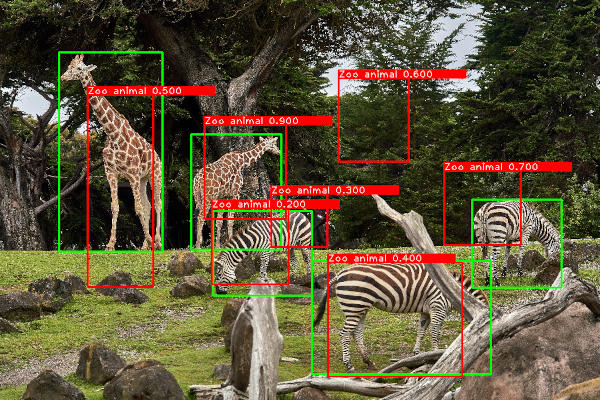

(Zoo Photo by <a href="https://unsplash.com/@nxn?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Nikolay Tchaouchev</a> on <a href="https://unsplash.com/collections/4109868/zoo?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>)

So, the first step of calculating mAP is to use IoU to measure how similar a prediction is to a ground truth box. Then, for every prediction, we can determine if it is an "accurate" prediction if the IoU is greater than some threshold. If you see a metric called mAP\@0.5 or AP50, then that means the mAP has been calculated using an IoU threshold of 0.5. A threshold of 0.5 is the most common.

**Question**: If we add 200 pixels to all of the detection boundaries in `detection_lbls`, would we still expect them to overlap well?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
Absolutely not. After moving the box half of the image away, it would no longer cover the object it has before.
</details>
<br />

**Question**: If we set a higher IoU threshold (say 0.9), what happens to the number of "accurate"/"true positive" detections?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
A higher IoU threshold means that predictions need to be more similar to the ground truth labels before it's considered a "true positive". Thus, the number of "true positives" will be lower, even using the same set of predictions from the model. Measuring mAP with a higher IoU threshold requires that all of your detections are high quality, which may be a requirement in some use cases, or may not be important to you.
</details>
<br />

**Question**: Looking at the zoo image on the right. How many ground truth (green) boxes are there? How many prediction (red) boxes are there? If we set the IoU threshold at 0.75, how many predictions would be considered a "true positive" (roughly)? How many at 0.1?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
There are 5 ground truth boxes. There are 7 prediction boxes.

With an IoU of 0.75, there needs to be a lot of overlap to be considered a "true positive", so we would expect only two zebra detections to be considered "true positives".

As for the case of IoU of 0.1, this is something of a trick question; before you can answer how many are "true positive" you have to decide how to handle multiple detections that cover the same ground truth (as in the case of the central zebra having two possible "accurate" predictions). You can either say that the box with the highest confidence or the box with the highest IoU gets to own that ground truth and no other predictions are allowed to match that ground truth. The former gives better mAP, the latter gives better matches. Regardless, although 6 boxes overlap enough to reach the IoU threshold, we would only have 5 "true positives".

</details>
<br />

The following code cell will go through the "predictions" in the zoo image and determine if they are true positives using `determine_positives()` from the above mAP implementation.

In [ ]:
# Constructing the predicted boxes with confidences in the expected form
img_idxs = [[1]]*7
# These confidences are completely hypothetical/made up
pred_confidences = [[0.5], [0.9], [0.3], [0.7], [0.4], [0.6], [0.2]]
zoo_detection_pred = load_detections(Path('tutor_lbls') / 'zoo-pred.txt')
pred_boxes = np.concatenate([
    img_idxs,
    zoo_detection_pred[:, 0:1],
    pred_confidences,
    zoo_detection_pred[:, 1:]
], axis=-1)
print('"Predicted" boxes:')
print(pred_boxes)

print('-'*50)
# Constructing the ground truth boxes in the expected form
img_idxs = [[1]]*5
confidences = [[1]]*5
zoo_detection_lbls = load_detections(Path('tutor_lbls') / 'zoo.txt')
gt_boxes = np.concatenate([
    img_idxs,
    zoo_detection_lbls[:, 0:1],
    confidences,
    zoo_detection_lbls[:, 1:]
], axis=-1)
print('Ground Truth boxes:')
print(gt_boxes)

print('-'*50)
is_tp = determine_positives(pred_boxes, gt_boxes, iou_thresh=0.5)
print("Confidences and is TP:")
pred_w_is_tp = np.concatenate([pred_boxes[:, 2:3], is_tp[:, None]], axis=-1)
print(pred_w_is_tp)

### 4.3.2 Calculate Precision/Recall

Once we have determined for each detection whether it is a "true positive", we can progressively calculate the precision/recall as we include more boxes based on a confidence threshold (**not** an IoU threshold). Below, we have the `pred_w_is_tp` variable as a table. From this table you can calculate the precision/recall you get when including each row and every row above it (recording the value in the row). The first three rows are done for you.

<table>
    <tr>
        <th>Confidence</th>
        <th>Is TP</th>
        <th>Precision</th>
        <th>Recall</th>
    </tr>
    <tr>
        <td>0.9</td>
        <td>1</td>
        <th>1/1</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.7</td>
        <td>0</td>
        <th>1/2</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.6</td>
        <td>0</td>
        <th>1/3</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.5</td>
        <td>1</td>
        <th>?/4</th>
        <th>?/5</th>
    </tr>
    <tr>
        <td>0.4</td>
        <td>1</td>
        <th>?/5</th>
        <th>?/5</th>
    </tr>
    <tr>
        <td>0.3</td>
        <td>0</td>
        <th>?</th>
        <th>?</th>
    </tr>
    <tr>
        <td>0.2</td>
        <td>1</td>
        <th>?</th>
        <th>?</th>
    </tr>
</table>

<details>
<summary style='cursor:pointer;'><u>Description/Hint</u></summary>
Each row in the table is a prediction.

For the first row, it is a TP, so the precision is 1/1, out of all rows we are considering (one), all of them (one) match a ground truth, and the recall is 1/5 because there are 5 ground truths, and we've found 1 of them.

For the second row, it is not a TP, so the precision is 1/2, because we're now considering 2 rows (this and the first), and the recall is still 1/5 because we haven't found any more ground truths.

For the third row, it is not a TP, so the precision is 1/3, because we've got 1 TP out of the three rows we're considering, and the recall is still 1/5, because we still haven't found more ground truths.
</details>
<br />

**Task**: Complete the table (on a piece of paper, or in excel, or whatever) and fill in the below code cell with the values in `my_precisions` and `my_recalls`. Check that you get the same values.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

<table>
    <tr>
        <th>Confidence</th>
        <th>Is TP</th>
        <th>Precision</th>
        <th>Recall</th>
    </tr>
    <tr>
        <td>0.9</td>
        <td>1</td>
        <th>1/1</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.7</td>
        <td>0</td>
        <th>1/2</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.6</td>
        <td>0</td>
        <th>1/3</th>
        <th>1/5</th>
    </tr>
    <tr>
        <td>0.5</td>
        <td>1</td>
        <th>2/4</th>
        <th>2/5</th>
    </tr>
    <tr>
        <td>0.4</td>
        <td>1</td>
        <th>3/5</th>
        <th>3/5</th>
    </tr>
    <tr>
        <td>0.3</td>
        <td>0</td>
        <th>3/6</th>
        <th>3/5</th>
    </tr>
    <tr>
        <td>0.2</td>
        <td>1</td>
        <th>4/7</th>
        <th>4/5</th>
    </tr>
</table>

</details>


In [ ]:
#TODO: fill in with values from table
#my_precisions = [1/1, 1/2, 1/3, ...]
#my_recalls =    [1/5, 1/5, 1/5, ...]
print('My Precisions')
#print(my_precisions)
print('My Recalls')
#print(my_recalls)
print('-'*20)

conf = np.array(pred_confidences)[:, 0]
precisions, recalls = precision_recall_curve(is_tp, conf, 5)
print('Precisions')
print(precisions[1:])
print('Recalls')
print(recalls[1:])

fig, ax = plt.subplots(1, 1)
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_xlim([0, 1.01])
_ = ax.set_ylim([0, 1.01])

#### Precision-Recall curve

In the above code cell we created a plot. This is a plot of recall vs precision.

**Question**: What is varying between successive data points in this plot?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
Between each successive data point, another row is being considered, and the recall/precision is being calculated using that row and every row before it. This is also known as "setting a confidence threshold".

This kind of plot may be difficult to follow at first. The data points are joined with a line because each successive data point includes one extra row than the data point before it. In a sense, the "time" is not shown on the graph.

The recall and precision are linked in some sense. We expect that if we only include predictions we are confident in (high confidence), the precision should stay high, and as we include less confident predictions, the precision will drop as we start to include predictions that are more likely to be wrong.
</details>

### 4.3.3 Average precision

Now we have the precisions and recalls, we measure the area under the curve using the [`np.trapz()` function](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html).

<details>
<summary style='cursor:pointer;'><u>More details: PASCAL VOC: Approximating the area under the curve</u></summary>
Since we have discrete data, <code>np.trapz()</code> will calculate the area precisely. Nevertheless, if you have a LOT of datapoints, perhaps you would want to approximate it to save time. The original mAP metric for PASCAL VOC used 11 evenly spaced confidence thresholds and the left-hand rule to estimate the area under the curve. We won't show how to do this here.
</details>

In [ ]:
# Calculated step-by-step
avg_precision1 = np.trapz(precisions, recalls)
# Use the function we gave you
avg_precision2 = mean_average_precision(pred_boxes, gt_boxes)
# Ensure they give the same answer
print(f'Step-by-step: {avg_precision1:1.5f}')
print(f'Using func:   {avg_precision2:1.5f}')

# 5. Mask RCNN

Mask RCNN is a well-known Deep Learning model for detection and instance segmentation. It is the de facto standard for high quality, generic object detectors. And with the power of `torchvision` we can very easily use it (assuming your computer can handle it).

**Task**: Download a pretrained Mask RCNN model. https://pytorch.org/vision/0.9/models.html

In [ ]:
# TODO - Download MaskRCNN using torchvision. Refer to docs/Lab3 if you need help
maskrcnn =

#### Task solution

In [ ]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

## 5.1 Run


In [ ]:
def preprocess_image(image):
    # Convert image to tensor
    image = tvtf.to_tensor(image)

    # Create a batch dimension
    image = image.unsqueeze(dim=0)

    return image

In [ ]:
maskrcnn.eval()
with torch.no_grad():
    output = maskrcnn(preprocess_image(park_img_rescaled))
# output[0] is the outputs for the first image. There is only one image in this case.
park_img_pred = output[0]

## 5.2 Visualise

Here we will display all of the boxes that MaskRCNN predicted. We print out the keys to see what information maskRCNN predicts:

  - 'boxes' are the bounding boxes
  - 'labels' are the class ids
  - 'scores' are the confidences
  - 'masks' are the segmentation masks

In [ ]:
for k, v in park_img_pred.items():
    print(f'{k:8s} shaped', tuple(v.shape))

park_img_det = np.concatenate([
    park_img_pred['labels'].detach().cpu().numpy()[:, None],
    park_img_pred['boxes'].detach().cpu().numpy().astype(np.int32)
], axis=-1)
img = park_img_rescaled.copy()
draw_detections(img, park_img_det)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.imshow(img)
_ = ax.axis('off')

Woah! That's a lot of boxes! MaskRCNN tends to produce a lot of boxes, however, remember that it also produces a confidence score for each box that it produces. MaskRCNN sorts it's boxes by that confidence for us, so if we want the top 6 most confident boxes, we can just select `park_img_det[:6]`.

**Question**: Exactly how many boxes are predicted? *Hint*: This is printed out in the above code cell.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
There are 46 predicted boxes.
</details>

In [ ]:
img = park_img_rescaled.copy()
h, w = img.shape[:2]

def draw_instance_segmentation_mask(img, masks):
    ''' Draws segmentation masks over an img '''
    seg_colours = np.zeros_like(img, dtype=np.uint8)
    for i, mask in enumerate(masks):
        col = (mask[0, :, :, None] * COLOURS[i])
        seg_colours = np.maximum(seg_colours, col.astype(np.uint8))
    cv2.addWeighted(img, 0.75, seg_colours, 0.75, 1.0, dst=img)

draw_instance_segmentation_mask(img, park_img_pred['masks'][:6].detach().cpu().numpy())
draw_detections(img, park_img_det[:6])

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.imshow(img)
_ = ax.axis('off')

Woah (times 2)! As you can see, MaskRCNN is a very good image detector and segmenter, and we didn't even need to do anything to the image to make it work! The folks at `torchvision` have put a lot of effort into making it so that you can use MaskRCNN without tweaking for most applications. However, it is a large model that takes a lot of processing and RAM, so it's not always able to be used (especially without a GPU).

## 5.3 Evaluate

MaskRCNN was not trained on our labels, so we can't use the predicted class at all. For simplicity, we'll just discard all class information and evaluate boxes as if everything was the same class.

**Question**: What do we expect the mAP to be in this case?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
Since the model has covered each object we labelled very well, we expect a mAP of 1.0 (100%).
</details>

In [ ]:
# mean_average_precision() expects boxes like [train_idx, class, confidence, tlx, tly, brx, bry]
n_boxes = len(park_img_pred['boxes'])
maskrcnn_pred_boxes = np.concatenate([
    np.zeros((n_boxes, 1)),
    np.zeros((n_boxes, 1)),
    park_img_pred['scores'].detach().cpu().numpy()[:, None],
    park_img_pred['boxes'].detach().cpu().numpy(),
], axis=-1)

n_labels = len(detection_lbls_rescaled)
maskrcnn_gt_boxes = np.concatenate([
    np.zeros((n_labels, 1)),
    np.zeros((n_labels, 1)),
    np.ones((n_labels, 1)),
    detection_lbls_rescaled[:, 1:], # discard class information
], axis=-1)

mAP = mean_average_precision(maskrcnn_pred_boxes, maskrcnn_gt_boxes)
print(f'Mean average precision: {mAP*100:3.2f}%')

Well done! You made it to the end of this weeks lab.

# Challenge questions

## Numpy slicing

Numpy slicing works in much the same way as python list slicing, except that it can be done over multiple dimensions at once. The code cell below has some examples of this. You are then asked to use numpy slicing to cleanly solve several tasks that might come up when you're dealing with detection and segmentation and images using numpy/torch.

In [ ]:
print('-'*50)
print(' - Python lists - ')
some_list = [3, 1, 1, 6, 5, 9, 7, 5, 3, 5, 0, 2, 3, 0, 5]
print(some_list)
# We can extract a single element
print('Single element: ')
print(some_list[0])
print(some_list[-5]) # a negative index counts backwards from the last element
# We can extract a sub-list with a range [start, stop)
print('Slices of array: ')
print(some_list[0:5])
print(some_list[9:-2]) # negative indices still work
# Internally, slicing like this is creating a "slice" object:
print('Using an explicit slice object: ')
a_slice_obj = slice(0, 5)
print(some_list[a_slice_obj])

print('-'*50)

print(' - Numpy arrays - ')
# This syntax carries over to numpy, except we have to consider multiple dimensions.
some_arr = np.array([
    [3, 1, 1, 6, 5],
    [9, 7, 5, 3, 5],
    [0, 2, 3, 0, 5],
])
print(some_arr)
# We can still extract a single element
print('Single element:')
print(some_arr[0, 0])
# We can extract a 1D array of numbers
print('One dimensional slice:')
print(some_arr[1, 0:4])
# But, we can also extract a 2D array of numbers
print('Two dimensional slice:')
print(some_arr[0:2, 0:4])

# And assignment follows the same rules, too
new_block = np.array([
    [4, 3],
    [2, 1]
])
# To assign a numpy array to a sub-region of another numpy array,
# the assigned data must match the shape of the sub array.
# In this case, we assign a 2x2 region with a 2D numpy array shaped 2x2.
print('Assigning new block of data:')
some_arr[0:2, 1:3] = new_block
print(some_arr)
# It is also worth noting that you can assign regions to a single value, too
print('Assigning zero:')
some_arr[1:3, 3:5] = 0
print(some_arr)

### Task

**Task**: Given the above information on numpy slicing and assigning:
1. Extract the pixels in `rand_detections[0]` from `copy_img` and `rand_img`.
2. Assign the region described by `rand_detections[1]` of `copy_img` to be all 50s.

In [ ]:
rand_img = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)
rand_detections = np.array([
    [2, 100, 150, 100, 200],
    [0,  50, 175,  25, 175],
    [1, 175, 200,  25,  50]
])

# Make a copy so we don't destroy the original
copy_img = rand_img.copy()

# TODO: Extract the pixels from rand_detections[0]
cl, tlx, brx, tly, bry = rand_detections[0]
#extracted_rand = rand_img[   ]
#extracted_copy = copy_img[   ]

# TODO: Assign the box described by rand_detections[1] to be 50
cl, tlx, brx, tly, bry = rand_detections[1]
#copy_img[   ] = 50

# Visualise
fig, axes = plt.subplots(1, 4, figsize=(25, 7))
axes[0].imshow(rand_img)
axes[0].set_title('Original random image')
axes[1].imshow(extracted_rand)
axes[1].set_title('Extracted region of original')
axes[2].imshow(extracted_copy)
axes[2].set_title('Extracted region of copy')
axes[3].imshow(copy_img)
_ = axes[3].set_title('Modified image')

#### Task solution

In [ ]:
rand_img = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)
rand_detections = np.array([
    [2, 100, 150, 100, 200],
    [0,  50, 175,  25, 175],
    [1, 175, 200,  25,  50]
])

# Make a copy so we don't destroy the original
copy_img = rand_img.copy()

# Extract the pixels from rand_detections[0]
cl, tlx, brx, tly, bry = rand_detections[0]
extracted_rand = rand_img[tly:bry, tlx:brx]
extracted_copy = copy_img[tly:bry, tlx:brx]
print(tly, bry, tlx, brx, extracted_rand.shape)

# Assign the box described by rand_detections[1] to be 50
cl, tlx, brx, tly, bry = rand_detections[1]
copy_img[tly:bry, tlx:brx] = 50

# Visualise
fig, axes = plt.subplots(1, 4, figsize=(25, 7))
axes[0].imshow(rand_img)
axes[0].set_title('Original random image')
axes[1].imshow(extracted_rand)
axes[1].set_title('Extracted region of original')
axes[2].imshow(extracted_copy)
axes[2].set_title('Extracted region of copy')
axes[3].imshow(copy_img)
_ = axes[3].set_title('Modified image')

### Question

<b>Question</b>: Given what you observe with the above code, does slicing (like `some_var = some_img[y1:y0, x1:x0]`) create a copy of the data, or does it just return a view into existing data?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Slicing does not make a copy of the data. It makes a view onto the exact same data. Any operations that modify the data in place will affect both arrays. You can tell because we sliced <code>copy_img</code> <i>before</i> we assigned the middle section to a single colour, and yet, <code>extracted_copy</code> has the equivalent positions set to that single colour.
</details>

### Task

**Task**: Use numpy slicing to construct an image from an empty image by using each class as a colour channel and drawing each `rand_detections` box in its classes channel.

In [ ]:
rand_detections = np.array([
    [2, 100, 150, 100, 200],
    [0,  50, 175,  25, 175],
    [1, 175, 200,  25,  50]
])

ze = np.zeros((224, 224, 3), dtype=np.uint8)
# TODO: For each channel of ze:
#       Create an image from the boxes with slicing.

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(ze)
_ = ax.axis('off')

#### Task solution

In [ ]:
for i, (cl, tlx, brx, tly, bry) in enumerate(rand_detections):
    ze[tly:bry, tlx:brx, i] = 255

### Task

**Task**: Use `rand_detections`, `rand_img` and the information on slicing and assigning in numpy to create a segmentation mask within each `rand_detection`. The mask should be `True` if the mean colour value at that position is greater than 122. *Tip*: The resulting image should look similar to the previous case, except with random pixels turned off.

In [ ]:
h, w = rand_img.shape[:2]
masks = np.zeros((h, w, 3))
# TODO - For each channel of masks:
#        Fill in a channel of masks according to the condition: ...mean(...) > 122

fig, axes = plt.subplots(1, 2, figsize=(7, 7))
axes[0].imshow(masks)
axes[1].imshow(rand_img)
axes[0].axis('off')
_ = axes[1].axis('off')

#### Task solution

In [ ]:
for i, (cl, tlx, brx, tly, bry) in enumerate(rand_detections):
    seg = (rand_img[tly:bry, tlx:brx].mean(axis=2) > 255/2)*1
    masks[tly:bry, tlx:brx, i] = seg

# Summary

In this lab we dove deep into the most common computer vision tasks. We explored labelling our own images to understand what form the labels take. We learned how to evaluate predictions. And we ran MaskRCNN on our test image to see what the state of the art can do.

# Next Lab

In next week's lab you will write your own detection algorithms using fundamental computer vision techniques.